In [10]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import matplotlib.pyplot as plt
import mysql.connector as mysql
import numpy as np
import base64
import PIL
from PIL import Image as Image
#from IPython.display import Image
#import urllib.parse
import io
import re
from app.src.db import *
%autoreload 2

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from matplotlib import pyplot as plt
import numpy as np

import requests
from io import BytesIO
from PIL import Image, ImageFilter
import os
os.environ['KERAS_BACKEND']='tensorflow'

In [13]:
mydb = mysql.connect(
    host="127.0.0.1",
    port=49157,
    user="root",
    password="datascience",
    database="racer")

X, Y = getDataset(mydb, 6, 1)
print(X.shape)
print(Y.shape)

(3294, 2500)
(3294, 3)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2206, 2500)
(1088, 2500)
(2206, 3)
(1088, 3)


In [15]:
def coeff_determination(y_true, y_pred):
    print("coeff_determination")
    from keras import backend as K
    print("1coeff done")
    SS_res =  K.sum(K.square( y_true-y_pred ))
    print("2coeff done")
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    print("3coeff done")
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def my_r2_score(v_true, v_pred):
    ssres = np.sum(np.square(v_true - v_pred))
    sstot = np.sum(np.square(v_true - np.mean(v_true)))
    return 1 - ssres / sstot

In [9]:
from tensorflow.keras.applications.vgg16 import VGG16, decode_predictions
vgg_16 = VGG16()

In [30]:
def buildModel(X_train, y_train, X_test, y_test, inputScaler=1, epochs=40):
    model = Sequential()
    model.add(Flatten(input_shape=(2500,1)))
    model.add(Dense(25, activation="relu"))
    model.add(Dense(3))
    #adam vs. sgd; adam works better
    model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.MeanSquaredError()])
    model.build()
    #model.summary()
    model.fit(X_train * inputScaler, y_train, epochs=40, validation_data=(X_test * inputScaler, y_test), verbose=0)
    
    y_train_predictions = model.predict(X_train * inputScaler)
    y_train_rsquared = my_r2_score(y_train_predictions, y_train)
    
    y_test_predictions = model.predict(X_test * inputScaler)
    y_test_rsquared = my_r2_score(y_test_predictions, y_test)
    
    print(f"inputScaler: {inputScaler}")
    print(f"Training R-Squared: {y_train_rsquared}")
    print(f"Test R-Squared: {y_test_rsquared}")
    return y_train_rsquared, y_test_rsquared

def buildModelSingleTask(X_train, y_train, X_test, y_test, optimizer='adam', loss='mean_squared_error', inputScaler=1, epochs=40, filename=None, verbose=1):
    model = Sequential()
    model.add(Flatten(input_shape=(2500,1)))
    model.add(Dense(160, activation="relu"))
    model.add(Dropout(.3))
    model.add(Dense(40, activation="relu"))
    model.add(Dropout(.3))
    model.add(Dense(10, activation="relu")) # lets try an intermediary layer of 625?
    model.add(Dense(1))
    #adam vs. sgd; adam works better
    model.compile(optimizer=optimizer,
              loss=loss,
              metrics=[tf.keras.metrics.MeanSquaredError()])
    model.build()
    #model.summary()
    model.fit(X_train * inputScaler, y_train, epochs=epochs, validation_data=(X_test * inputScaler, y_test), verbose=verbose)
    
    y_train_predictions = model.predict(X_train * inputScaler)
    y_train_rsquared = my_r2_score(y_train_predictions, y_train)
    
    y_test_predictions = model.predict(X_test * inputScaler)
    y_test_rsquared = my_r2_score(y_test_predictions, y_test)
    
    print(f"y_train.shape: {y_train.shape}")
    print(f"y_train_predictions.shape: {y_train_predictions.shape}")
    print(f"y_test.shape: {y_test.shape}")
    print(f"y_test_predictions.shape: {y_test_predictions.shape}")
    print(f"inputScaler: {inputScaler}")
    print(f"Training R-Squared: {y_train_rsquared}")
    print(f"Test R-Squared: {y_test_rsquared}")
    
    y_train_position_predicted = model.predict(X_train/255)
    y_test_position_predicted = model.predict(X_test/255)
    print(y_train_position_predicted.shape)
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    ax[0].scatter(x=y_train.reshape(-1,1), y=y_train_predictions[:,0])
    ax[1].scatter(x=y_test.reshape(-1,1), y=y_test_predictions[:,0])
    ax[0].set_title(f"training r^2={y_train_rsquared}")
    ax[0].set_ylabel("predicted positions")
    ax[1].set_title(f"test r^2={y_test_rsquared}")
    ax[0].set_xlabel("actual positions")
    ax[1].set_xlabel("actual positions")
    if filename != None:
        plt.savefig(filename)
    return y_train_rsquared, y_test_rsquared, model


def evaluateModel(X_train, y_train, X_test, y_test, builder, epoch_range, inputScaler=1):
    train_rsquared = []
    test_rsquared = []
    for epoch in epoch_range:
        train, test = builder(X_train, y_train, X_test, y_test, inputScaler=inputScaler, epochs=epoch)
        train_rsquared.append(train)
        test_rsquared.append(test)
        fig,ax = plt.subplots(1,1,figsize=(5,5))
        ax.plot(epochs[:len(train_rsquared)], train_rsquared,c='r')
        ax.plot(epochs[:len(train_rsquared)], test_rsquared,c='b')
        ax.set_ylim(0,1)
        plt.tight_layout()
        ax.set_title(f"epoch={epoch}")
        plt.show()
    return epoch_range, train_rsquared, test_rsquared

(2206,)
(2206,)
(2206,)
(1088,)
(1088,)
(1088,)


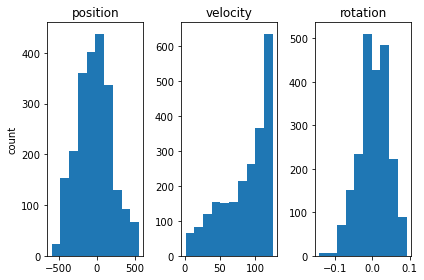

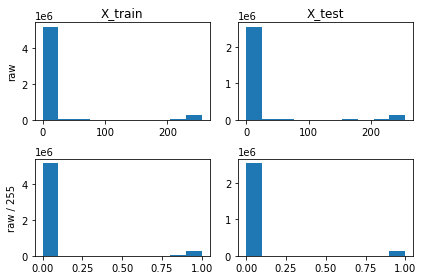

In [18]:
y_train_position = y_train[:,0]
y_train_velocity = y_train[:,1]
y_train_rotation = y_train[:,2]
print(y_train_position.shape)
print(y_train_velocity.shape)
print(y_train_rotation.shape)
y_test_position = y_test[:,0]
y_test_velocity = y_test[:,1]
y_test_rotation = y_test[:,2]
print(y_test_position.shape)
print(y_test_velocity.shape)
print(y_test_rotation.shape)

fig, ax = plt.subplots(1,3)
ax[0].hist(y_train_position)
ax[0].set_title("position")
ax[0].set_ylabel("count")
ax[1].hist(y_train_velocity)
ax[1].set_title("velocity")
ax[2].hist(y_train_rotation)
ax[2].set_title("rotation")
plt.tight_layout()
plt.savefig("y_eda.png")
plt.show()


fig, ax = plt.subplots(2,2)
ax[0,0].hist(X_train.reshape(-1,1))
ax[0,1].hist(X_test.reshape(-1,1))
ax[0,0].set_title("X_train")
ax[0,0].set_ylabel("raw")
ax[0,1].set_title("X_test")
ax[1,0].hist(X_train.reshape(-1,1)/255)
ax[1,0].set_ylabel("raw / 255")
ax[1,1].hist(X_test.reshape(-1,1)/255)
plt.tight_layout()
plt.savefig("x_eda.png")
plt.show()

Epoch 1/100
69/69 [==============================] - 1s 7ms/step - loss: 53877.3008 - mean_squared_error: 53877.3008 - val_loss: 48255.5391 - val_mean_squared_error: 48255.5391
Epoch 2/100
69/69 [==============================] - 0s 7ms/step - loss: 48850.9414 - mean_squared_error: 48850.9414 - val_loss: 44563.2695 - val_mean_squared_error: 44563.2695
Epoch 3/100
69/69 [==============================] - 0s 7ms/step - loss: 44665.8008 - mean_squared_error: 44665.8008 - val_loss: 41312.5977 - val_mean_squared_error: 41312.5977
Epoch 4/100
69/69 [==============================] - 0s 7ms/step - loss: 40967.9727 - mean_squared_error: 40967.9727 - val_loss: 38744.1172 - val_mean_squared_error: 38744.1172
Epoch 5/100
69/69 [==============================] - 0s 7ms/step - loss: 38120.9180 - mean_squared_error: 38120.9180 - val_loss: 36384.6758 - val_mean_squared_error: 36384.6758
Epoch 6/100
69/69 [==============================] - 0s 7ms/step - loss: 35777.5312 - mean_squared_error: 35777.531

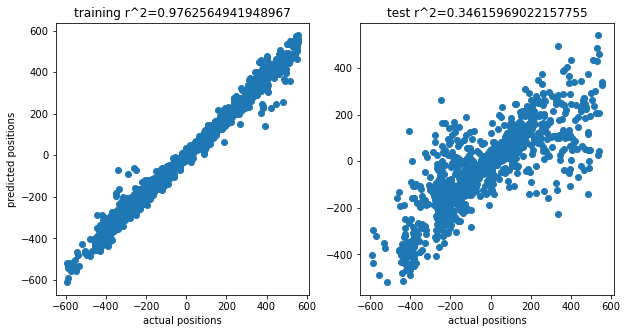

In [31]:
train_rsquared, test_rsquared, modelPosition  = buildModelSingleTask(X_train, y_train_position.reshape(-1,1), X_test, y_test_position.reshape(-1,1), optimizer= tf.keras.optimizers.RMSprop(learning_rate=0.00005), loss='mean_squared_error', inputScaler=1, epochs=100, filename="alpha.5layer.2-30pctdrop.rmsprop00005.mse.unnormalized.100epochs.png")

Epoch 1/500
69/69 [==============================] - 0s 3ms/step - loss: 63790784.0000 - mean_squared_error: 63790784.0000 - val_loss: 145660.6250 - val_mean_squared_error: 145660.6250
Epoch 2/500
69/69 [==============================] - 0s 2ms/step - loss: 77868.1016 - mean_squared_error: 77868.1016 - val_loss: 41974.5195 - val_mean_squared_error: 41974.5195
Epoch 3/500
69/69 [==============================] - 0s 2ms/step - loss: 52617.2969 - mean_squared_error: 52617.2969 - val_loss: 41503.8984 - val_mean_squared_error: 41503.8984
Epoch 4/500
69/69 [==============================] - 0s 2ms/step - loss: 49991.6367 - mean_squared_error: 49991.6367 - val_loss: 41826.1641 - val_mean_squared_error: 41826.1641
Epoch 5/500
69/69 [==============================] - 0s 2ms/step - loss: 46728.4883 - mean_squared_error: 46728.4883 - val_loss: 43938.9453 - val_mean_squared_error: 43938.9453
Epoch 6/500
69/69 [==============================] - 0s 2ms/step - loss: 44219.9180 - mean_squared_error: 4

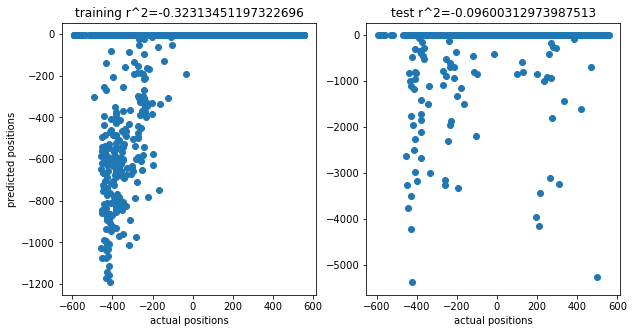

In [201]:
train_rsquared, test_rsquared, modelPosition  = buildModelSingleTask(X_train, y_train_position.reshape(-1,1), X_test, y_test_position.reshape(-1,1), optimizer= tf.keras.optimizers.RMSprop(learning_rate=0.1), loss='mean_squared_error', inputScaler=1, epochs=500, filename="alpha.rmsprop.unnormalized.500epochs.png")

Epoch 1/1000
69/69 [==============================] - 0s 3ms/step - loss: 40184.7852 - mean_squared_error: 40184.7852 - val_loss: 28796.0977 - val_mean_squared_error: 28796.0977
Epoch 2/1000
69/69 [==============================] - 0s 5ms/step - loss: 20573.9121 - mean_squared_error: 20573.9121 - val_loss: 24183.7031 - val_mean_squared_error: 24183.7031
Epoch 3/1000
69/69 [==============================] - 0s 2ms/step - loss: 13508.8164 - mean_squared_error: 13508.8164 - val_loss: 21783.9863 - val_mean_squared_error: 21783.9863
Epoch 4/1000
69/69 [==============================] - 0s 2ms/step - loss: 9945.4805 - mean_squared_error: 9945.4805 - val_loss: 21773.6426 - val_mean_squared_error: 21773.6426
Epoch 5/1000
69/69 [==============================] - 0s 2ms/step - loss: 7183.6040 - mean_squared_error: 7183.6040 - val_loss: 19697.7559 - val_mean_squared_error: 19697.7559
Epoch 6/1000
69/69 [==============================] - 0s 1ms/step - loss: 5188.3438 - mean_squared_error: 5188.343

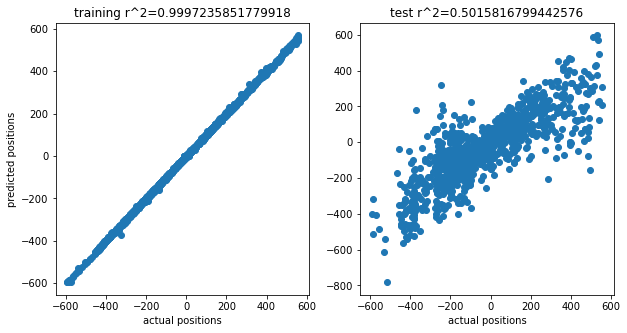

In [184]:
train_rsquared, test_rsquared, modelPosition  = buildModelSingleTask(X_train, y_train_position.reshape(-1,1), X_test, y_test_position.reshape(-1,1), inputScaler=1, epochs=1000, filename="alpha.unnormalized.1000epochs.png")